<a href="https://colab.research.google.com/github/7angel4/weighted-jk/blob/main/JKGCN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [1]:
!python -c "import torch; print(torch.__version__)"

2.6.0.dev20241112


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
# suppress warnings
import warnings

# Suppress specific UserWarning related to InMemoryDataset
warnings.simplefilter("ignore", category=UserWarning)

#### Import required packages

Please run the below code block to import the required python packages.

In [66]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets
import numpy as np

from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

In [67]:
torch.manual_seed(87878) # set seed

In [68]:
%run datasets.ipynb

In [69]:
%run models.ipynb

## 2. `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

In [33]:
import torch.optim as optim
from torch_geometric.data import Data
from sklearn.metrics import f1_score
import json
import functools

In [34]:
EVAL_METRICS = ['mic_f1', 'mac_f1']
DEFAULT_CMP_BY = 'mic_f1'

@functools.total_ordering
class EvalResults(dict):
    def __init__(self, mic_f1, mac_f1, cmp_by=DEFAULT_CMP_BY):
        super().__init__({
            'mic_f1': mic_f1,
            'mac_f1': mac_f1
        })
        self.cmp_by = cmp_by

    def __lt__(self, other):
        if not isinstance(other, EvalResults):
            return NotImplemented
        fst = self.cmp_by
        snd = [m for m in EVAL_METRICS if m != self.cmp_by][0]
        if self[fst] < other[fst]:
            return True
        elif self[fst] > other[fst]:
            return False
        # self[fst] = other[fst]
        elif self[snd] < other[snd]:
            return True
        else:
            return False 

    def __eq__(self, other):
        if not isinstance(other, EvalResults):
            return NotImplemented
        # Equal if all metrics are the same
        return all(self[m] == other[m] for m in EVAL_METRICS)

    def __le__(self, other):
        return self < other or self == other

    def __repr__(self):
        return (f"mic_f1: {self['mic_f1']:.4f}, "
                f"mac_f1: {self['mac_f1']:.4f}")

    def to_dict(self):
        return { 'mic_f1': self['mic_f1'], 'mac_f1': self['mac_f1'] }

    def to_serialisable(self):
        return { k:str(v) for k,v in self.to_dict().items() }

    @staticmethod
    def average(results, std=True):
        mic_f1s = [res['mic_f1'] for res in results]
        mac_f1s = [res['mac_f1'] for res in results]

        avgs = EvalResults(np.mean(mic_f1s), np.mean(mac_f1s))
        stds = None if not std else EvalResults(np.std(mic_f1s), np.std(mac_f1s))
        
        return avgs, stds

In [35]:
def evaluate(model, data, mask, cmp_by=DEFAULT_CMP_BY):
    """
    Evaluates model and returns its validation accuracy, 
    micro-F1 and macro-F1 scores on given mask.
    """
    model.eval()
    with torch.no_grad():  # disable gradient computation during evaluation
        # forward pass
        out = model(data.x, data.edge_index)
        # predict the class with max score
        pred = out.argmax(dim=1)
        true_labels = data.y[mask]
        # calculate F1 scores (`f1_score` expects the inputs to be on the CPU)
        mic_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='micro') # equivalent to accuracy for this task
        mac_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='macro')

    return EvalResults(mic_f1, mac_f1, cmp_by=cmp_by)

In [36]:
def init_training(params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data, dataset = load_data(params['dataset'], data_only=False)
    params["n_classes"] = dataset.num_classes  # number of target classes
    params["input_dim"] = dataset.num_features  # size of input features
    
    model = set_model(params, device)
    model.param_init()
    
    optimiser = optim.Adam(model.parameters(), 
                           lr=params['lr'], 
                           weight_decay=params['weight_decay'])
    loss_fn = nn.CrossEntropyLoss()
    
    return model, data, optimiser, loss_fn

In [37]:
def train_only(params: typing.Dict,
               cmp_by=DEFAULT_CMP_BY,
               report_per_period=1000,
               print_results=True):
    """
    Trains a node classification model and
    returns the trained model object.
    """
    model, data, optimiser, loss_fn = init_training(params)
    n_epochs = params['epochs']

    # variables for early stopping
    best_results = EvalResults(-1,-1)  # best validation results
    prev_loss = float('inf')
    consec_worse_epochs = 0  # number of consecutive epochs with degrading results
    # k: stop if epochs_dec_acc >= patience
    patience = params['max_patience']

    # standard training with backpropagation
    for epoch in range(n_epochs):
        model.train()
        optimiser.zero_grad()
        out = model(data.x, data.edge_index) # forward pass
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # backward pass
        optimiser.step()

        # evaluate on validation set
        results = evaluate(model, data, data.val_mask, cmp_by=cmp_by)

        # early stopping
        if results >= best_results:
            best_results = results
            consec_worse_epochs = 0
        else:
            consec_worse_epochs += 1

        # patience exceeded -> stop training
        if consec_worse_epochs >= patience:
            if print_results:
                print(f"Early stopping at epoch {epoch+1}")
                print(f"Best results: {best_results}")
            break

        # print training progress
        if (epoch+1) % report_per_period == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}...")
            print(f"Loss: {loss};")
            print(f"Validation Results:\n{results}\n")

    return model, best_results

In [38]:
def train_and_tune(params, hyperparam, hyperparam_values, 
                   cmp_by=DEFAULT_CMP_BY,
                   report_per_period=1000,
                   print_results=True):
    """
    Trains the model and performs hyperparameter tuning.

    Args:
    - params: Training parameters.
    - hyperparam: Name of the hyperparameter to tune (if any).
    - hyperparam_values: Values to test for the hyperparameter (if any).
    - report_per_period: Frequency of training status reports.
    - metric: Metric to optimise during training; one of ["accuracy", "micro_f1", or "macro_f1"].

    Returns:
    - if hyperparam_values = None, a pair: (trained model, its training performance) - same as [train]
    - otherwise, a triple: (optimal trained model, ts training performance, its hyperparameter value)
    """
    best_hyperparam_val, best_model = None, None, 
    best_results = EvalResults(-1,-1)

    for val in hyperparam_values:
        params[hyperparam] = val
        model, results = train_only(params, cmp_by, 
                                    report_per_period, 
                                    print_results)
        if results > best_results:
            best_results = results
            best_hyperparam_val = val
            best_model = model

    return best_model, best_results, best_hyperparam_val

In [39]:
def train(params, hyperparam=None, 
          hyperparam_values=None, 
          cmp_by=DEFAULT_CMP_BY,
          report_per_period=1000,
          print_results=True):
    """
    Wrapper training function.
    Returns a triple: (model, training results, training hyperparameters)
    """
    model_name = params['model_name']
    if model_name not in MODEL_SPEC_HYPERPARAM: # train without tuning
        model, res = train_only(params, cmp_by, report_per_period, print_results)
        return model, res, params
    else: 
        model, res, hyperparam_val = train_and_tune(params, hyperparam, 
                                                    hyperparam_values, 
                                                    cmp_by, report_per_period, 
                                                    print_results)
        tuned_hyperparam = MODEL_SPEC_HYPERPARAM[model_name]
        params[tuned_hyperparam] = hyperparam_val
        return model, res, params

In [40]:
TRAIN_LAYERS = range(2,21,2)

In [41]:
def train_diff_layers_model(params,
                            layers=TRAIN_LAYERS,
                            cmp_by=DEFAULT_CMP_BY,
                            report_per_period=100,
                            print_results=True):
    model_name = params['model_name']
    hyperparam = MODEL_SPEC_HYPERPARAM.get(model_name, None)
    hyperparam_values = MODEL_HYPERPARAM_RANGE.get(model_name, None)
    
    layers_to_model = dict()
    layers_to_hyperparams = dict()
    for n in layers:
        curr_params = params.copy()
        curr_params['n_layers'] = n
        model, res, hyperparams = train(curr_params, hyperparam, hyperparam_values, 
                                        cmp_by, report_per_period, print_results)
        layers_to_model[n] =  model
        layers_to_hyperparams[n] = hyperparams

    return layers_to_model, layers_to_hyperparams

## Testing

In [42]:
def test(model, dataset_name):
    data = load_data(dataset_name, data_only=True)
    return evaluate(model, data, data.test_mask)

In [43]:
import json

def train_and_test(params,
                   layers=TRAIN_LAYERS,
                   cmp_by=DEFAULT_CMP_BY,
                   report_per_period=1000,
                   print_results=True,
                   export_results=True):
    dataset_name = params['dataset']
    model_name = params['model_name']
    layers_to_model, layers_to_hyperparams = train_diff_layers_model(params, 
                                                                     layers, 
                                                                     cmp_by,
                                                                     report_per_period,
                                                                     print_results)
    layers_to_results = dict()  # number of layers : test results
    for n, model in layers_to_model.items():
        layers_to_results[n] = test(model, dataset_name)
        layers_to_model[n] = model
        if export_results:
            torch.save(model.state_dict(), f'./results/{dataset_name}/{n}_layers.pt')

    if print_results:
        print(f"Test results for {model_name} on {dataset_name}:")
        for n, results in layers_to_results.items():
            print(f"{n}-layer model:")
            print(f"Hyperparameter setting:")
            print(layers_to_hyperparams[n])
            print(results)
        print()
    if export_results:
        with open(f'./results/{dataset_name}/results.json', 'w') as fp:
            data = {n : metrics.to_serialisable() for n,metrics in layers_to_results.items() }
            json.dump(data, fp, indent=4)

    return layers_to_model, layers_to_results, layers_to_hyperparams

In [44]:
def repeat_experiment(params, num_runs=5):
    all_runs = [ train_and_test(params, layers=TRAIN_LAYERS, 
                                report_per_period=params['epochs']+1,
                                print_results=False)
                     for _ in range(num_runs) ]
    all_run_results = {}  # num layers : list of results across all runs
    all_run_hyperparams = {}
    all_run_models = {}
    for n in TRAIN_LAYERS:
        all_run_models[n] = [run[0][n] for run in all_runs]
        all_run_results[n] = [run[1][n] for run in all_runs]
        all_run_hyperparams[n] = [run[2][n] for run in all_runs]
        
    avg_results = {n : EvalResults.average(results, std=True)
                   for (n, results) in all_run_results.items()}
    return all_run_models, avg_results, all_run_hyperparams

In [104]:
DEFAULT_TRAINING_PARAMS = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 400,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "init_res_weight": 0
}

def training_params(model_name, dataset_name, init_res_weight=0, n_layers=2):
    params = DEFAULT_TRAINING_PARAMS.copy()
    params['model_name'] = model_name
    params['dataset'] = dataset_name
    params['init_res_weight'] = init_res_weight
    params['n_layers'] = n_layers
    return params

In [46]:
cora_results = { model: repeat_experiment(training_params(model, 'Cora'), num_runs=5)
                 for model in MODELS }

In [117]:
pubmed_results = { model: repeat_experiment(training_params(model, 'PubMed'), num_runs=5)
                   for model in MODELS }
citeseer_results = { model: repeat_experiment(training_params(model, 'CiteSeer'), num_runs=5)
                     for model in MODELS }

In [53]:
# train_and_test({'lr': 0.01,
#   'weight_decay': 0.0005,
#   'epochs': 400,
#   'max_patience': 5,
#   'hid_dim': 64,
#   'model_name': 'WSkipGNN',
#   'dataset': 'PubMed',
#   'n_layers': 20,
#   'init_res_weight': 0.7,
#   'n_classes': 3,
#   'input_dim': 500}, layers=[20])

In [54]:
def extract_models(experiment_results, layers=range(2,21,6)):
    # {model : {num layers : 2 } }
    all_res = { model: res[0] for (model, res) in experiment_results.items() }
    return {model: {n: res[n] for n in layers} for model, res in all_res.items()}

In [130]:
def extract_all_init_res_weights(experiment_results, layers=TRAIN_LAYERS):
    layers_to_hyperparams = experiment_results['WSkipGNN'][2]
    return {n: [ hp['init_res_weight'] for hp in hps ] 
            for n,hps in layers_to_hyperparams.items() if n in layers}

In [132]:
extract_all_init_res_weights(cora_results)

{2: [-0.20000000000000018,
  -0.20000000000000018,
  0.3999999999999997,
  -1.0,
  -0.20000000000000018],
 4: [-2.220446049250313e-16,
  -0.8,
  -1.0,
  -0.6000000000000001,
  0.19999999999999973],
 6: [-0.6000000000000001,
  0.9999999999999996,
  -0.20000000000000018,
  -0.8,
  0.9999999999999996],
 8: [-1.0, -0.20000000000000018, -1.0, -0.6000000000000001, -0.8],
 10: [-0.6000000000000001, -1.0, -0.8, -0.8, -0.8],
 12: [-1.0, -0.8, -1.0, -1.0, -0.8],
 14: [-0.6000000000000001, -1.0, -1.0, -0.8, -1.0],
 16: [-0.8, -1.0, -1.0, -0.8, -1.0],
 18: [-0.8, -0.8, -0.8, 0.7999999999999996, -0.8],
 20: [-0.8, -1.0, -1.0, -1.0, -0.8]}

In [56]:
def extract_all_final_res_weights(experiment_results, layers=TRAIN_LAYERS):
    layers_to_models = extract_models(experiment_results, layers=layers)['WSkipGNN']
    return { n: [float(m.res_weight) for m in models] 
                    for n, models in layers_to_models.items() }

In [57]:
def extract_results(experiment_results, layers=range(2,21,6)):
    # {model : {num layers : (mean metrics, std metrics) } }
    all_res = { model: res[1] for (model, res) in experiment_results.items() }
    return {model: {n: res[n] for n in layers} for model, res in all_res.items()}

In [118]:
cora_results['WSkipGNN']

({2: [WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1): GCNConv(64, 64)
     )
     (mlp): Linear(in_features=64, out_features=7, bias=True)
   ),
   WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1): GCNConv(64, 64)
     )
     (mlp): Linear(in_features=64, out_features=7, bias=True)
   ),
   WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1): GCNConv(64, 64)
     )
     (mlp): Linear(in_features=64, out_features=7, bias=True)
   ),
   WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1): GCNConv(64, 64)
     )
     (mlp): Linear(in_features=64, out_features=7, bias=True)
   ),
   WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1): GCNConv(64, 64)
     )
     (mlp): Linear(in_features=64, out_features=7, bias=True)
   )],
  4: [WSkipGNN(
     (layers): ModuleList(
       (0): GCNConv(1433, 64)
       (1-3): 3 x GCNConv(64, 64)
     )
     (mlp): Linea

In [159]:
def stderr(xs):
    return np.std(xs, ddof=1) / np.sqrt(len(xs))

In [160]:
import numpy as np
import matplotlib.pyplot as plt

def plot_res_weights(experiment_results, dataset_name, layers=range(2,21,6)):
    layers_to_init_ws = extract_all_init_res_weights(experiment_results, layers=layers)
    # map weights across all runs to mean, std
    layers_to_mean_init = { n: np.mean(ws) for n,ws in layers_to_init_ws.items() }
    layers_to_stderr_init = { n: stderr(ws) for n,ws in layers_to_init_ws.items() }
    # plot with error bars for initial weights
    init_line = plt.errorbar(layers, layers_to_mean_init.values(), yerr=layers_to_stderr_init.values(),
                             label='Initial', color='blue', markersize=4,
                             fmt='o', capsize=3, linestyle='-')

    # Add labels for initial weights (above the line)
    for i, layer in enumerate(layers):
        plt.text(layer, layers_to_mean_init[layer] + 0.1, # vertical gap
                 f'{layers_to_mean_init[layer]:.2f}', ha='center', va='bottom', 
                 fontsize=9, color=init_line[0].get_color(), fontweight='bold')

    layers_to_ws = extract_all_final_res_weights(experiment_results, layers=layers)
    layers_to_mean_final = { n: np.mean(ws) for n,ws in layers_to_ws.items() }
    layers_to_stderr_final = { n: stderr(ws) for n,ws in layers_to_ws.items() }
    # plot with error bars for final weights
    final_line = plt.errorbar(layers, layers_to_mean_final.values(), yerr=layers_to_stderr_final.values(),
                              label='Final', color='red', markersize=4,
                              fmt='o', capsize=3, linestyle='-')

    # Add labels for final weights (below the line)
    for i, layer in enumerate(layers):
        plt.text(layer, layers_to_mean_final[layer] - 0.1, 
                 f'{layers_to_mean_final[layer]:.2f}', ha='center', va='top', 
                 fontsize=9, color=final_line[0].get_color(), fontweight='bold')

    # Add plot labels and title
    plt.xlabel('Depth (t)')
    plt.ylabel('Residual weight (w(t))')
    plt.title('Initial vs. Final Residual Weights over Increasing Depths')
    plt.legend()
    plt.savefig(f'./results/{dataset_name}/res_weights.png', format='png')
    
    # Show the plot
    plt.xticks(layers)
    plt.yticks(np.arange(-1,1.1,0.2))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return layers_to_mean_final, layers_to_stderr_final

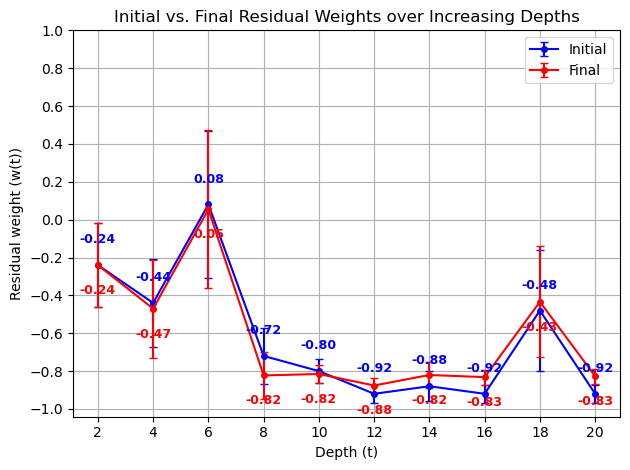

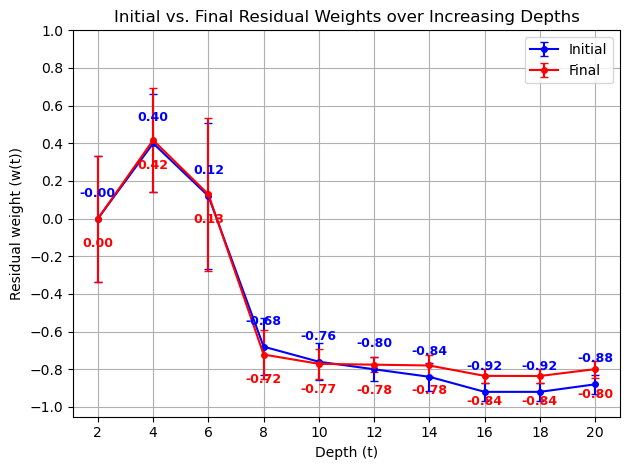

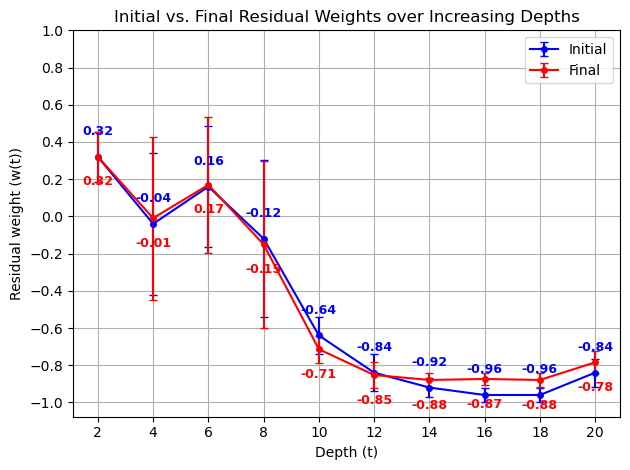

In [161]:
dataset_to_results = {'Cora': cora_results, 'CiteSeer': citeseer_results, 'PubMed': pubmed_results}
for dataset, results in dataset_to_results.items():
    plot_res_weights(results, dataset, layers=TRAIN_LAYERS)

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_res_weights(dataset_to_results, layers=range(2,21,6), label_vals=False):
    colors = {'Cora': 'blue', 'PubMed': 'green', 'CiteSeer': 'red'}
    # init_colors = {k: mcolors.CSS4_COLORS[v] for k,v in init_colors.items()}
    # final_colors = {'Cora': 'darkblue', 'PubMed': 'darkgreen', 'CiteSeer': 'darkred'}
    # final_colors = {k: mcolors.CSS4_COLORS[v] for k,v in final_colors.items()}
    dataset_to_mean_ws, dataset_to_stderr_ws = {}, {}
                   
    for dataset_name in DATASETS:
        experiment_results = dataset_to_results[dataset_name]
        layers_to_init_ws = extract_all_init_res_weights(experiment_results, layers=layers)
        # map weights across all runs to mean, std
        layers_to_mean_init = { n: np.mean(ws) for n,ws in layers_to_init_ws.items() }
        layers_to_stderr_init = { n: stderr(ws) for n,ws in layers_to_init_ws.items() }
        # plot with error bars for initial weights
        init_line = plt.errorbar(layers, layers_to_mean_init.values(), yerr=layers_to_stderr_init.values(),
                                 label=f'{dataset_name} - Initial', color=colors[dataset_name], markersize=3,
                                 fmt='o', capsize=3, linestyle=':')
    
        layers_to_ws = extract_all_final_res_weights(experiment_results, layers=layers)
        layers_to_mean_final = { n: np.mean(ws) for n,ws in layers_to_ws.items() }
        layers_to_std_final = { n: stderr(ws) for n,ws in layers_to_ws.items() }
        # plot with error bars for final weights
        final_line = plt.errorbar(layers, layers_to_mean_final.values(), yerr=layers_to_std_final.values(),
                                  label=f'{dataset_name} - Final', color=colors[dataset_name], markersize=3,
                                  fmt='o', capsize=3, linestyle='-')
        
        dataset_to_mean_ws[dataset_name] = layers_to_mean_final
        dataset_to_stderr_ws[dataset_name] = layers_to_std_final

        # Add labels
        if label_vals:
            for i, layer in enumerate(layers):
                # for initial weights (above the line)
                plt.text(layer, layers_to_mean_init[layer] + 0.1, # vertical gap
                         f'{layers_to_mean_init[layer]:.2f}', ha='center', va='bottom', 
                         fontsize=9, color=init_line[0].get_color(), fontweight='bold')
                # for final weights (below the line)
                plt.text(layer, layers_to_mean_final[layer] - 0.1, 
                         f'{layers_to_mean_final[layer]:.2f}', ha='center', va='top', 
                         fontsize=9, color=final_line[0].get_color(), fontweight='bold')
    
    # Add plot labels and title
    plt.xlabel('Depth (t)')
    plt.ylabel('Residual weight (w(t))')
    plt.title('Initial vs. Final Residual Weights over Increasing Depths')
    plt.legend()
    plt.savefig(f'./results/res_weights.png', format='png')
    
    # Show the plot
    plt.yticks(np.arange(-1,1.1,0.2))
    plt.xticks(layers)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return dataset_to_mean_ws, dataset_to_stderr_ws

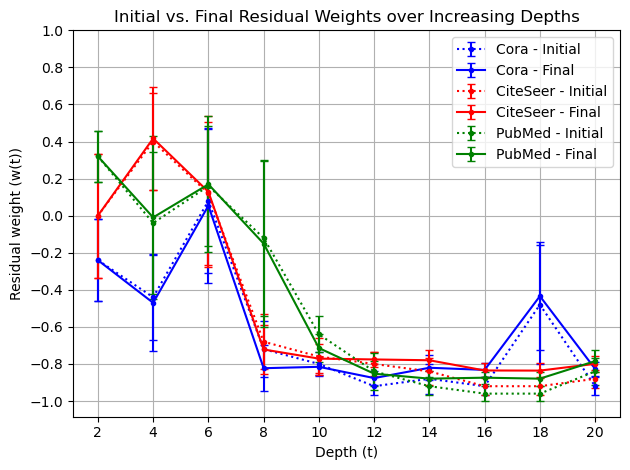

({'Cora': {2: -0.24000000059604645,
   4: -0.4700722806621343,
   6: 0.05404800772666931,
   8: -0.822844409942627,
   10: -0.8154059648513794,
   12: -0.8761218190193176,
   14: -0.8204541206359863,
   16: -0.8319651246070862,
   18: -0.43408302068710325,
   20: -0.8267160773277282},
  'CiteSeer': {2: 0.0,
   4: 0.41663115918636323,
   6: 0.12890626192092897,
   8: -0.7217857837677002,
   10: -0.7710992395877838,
   12: -0.7756174564361572,
   14: -0.7799771428108215,
   16: -0.83512442111969,
   18: -0.8357826948165894,
   20: -0.7992868661880493},
  'PubMed': {2: 0.320000010728836,
   4: -0.009362244606018066,
   6: 0.16936392784118653,
   8: -0.1506190061569214,
   10: -0.7140795826911926,
   12: -0.8525484323501586,
   14: -0.8791971325874328,
   16: -0.8740366458892822,
   18: -0.8791977643966675,
   20: -0.7846557974815369}},
 {'Cora': {2: 0.22271057528933588,
   4: 0.2595253000771934,
   6: 0.417661491928406,
   8: 0.12264676604292231,
   10: 0.045958083036498204,
   12: 0.0372

In [174]:
dataset_to_results = {'Cora': cora_results, 'CiteSeer': citeseer_results, 'PubMed': pubmed_results}
plot_res_weights(dataset_to_results, layers=TRAIN_LAYERS)

In [88]:
extract_results(cora_results, layers=[2,10,20])

{'PlainGNN': {2: (mic_f1: 0.7850, mac_f1: 0.7827,
   mic_f1: 0.0088, mac_f1: 0.0090),
  4: (mic_f1: 0.7698, mac_f1: 0.7654, mic_f1: 0.0151, mac_f1: 0.0113),
  6: (mic_f1: 0.5764, mac_f1: 0.5875, mic_f1: 0.2123, mac_f1: 0.1963),
  8: (mic_f1: 0.4902, mac_f1: 0.4911, mic_f1: 0.1463, mac_f1: 0.1585)},
 'SkipGNN': {2: (mic_f1: 0.7872, mac_f1: 0.7850,
   mic_f1: 0.0075, mac_f1: 0.0075),
  4: (mic_f1: 0.7644, mac_f1: 0.7582, mic_f1: 0.0160, mac_f1: 0.0127),
  6: (mic_f1: 0.7578, mac_f1: 0.7566, mic_f1: 0.0057, mac_f1: 0.0050),
  8: (mic_f1: 0.7150, mac_f1: 0.7163, mic_f1: 0.0097, mac_f1: 0.0114)},
 'JumpKGNN': {2: (mic_f1: 0.7886, mac_f1: 0.7852,
   mic_f1: 0.0110, mac_f1: 0.0090),
  4: (mic_f1: 0.7618, mac_f1: 0.7618, mic_f1: 0.0127, mac_f1: 0.0100),
  6: (mic_f1: 0.1770, mac_f1: 0.1091, mic_f1: 0.0124, mac_f1: 0.0278),
  8: (mic_f1: 0.1654, mac_f1: 0.1165, mic_f1: 0.0588, mac_f1: 0.0712)},
 'WSkipGNN': {2: (mic_f1: 0.7876, mac_f1: 0.7845,
   mic_f1: 0.0069, mac_f1: 0.0066),
  4: (mic_f1: 0

In [28]:
print('Cora:')
extract_results(cora_results, layers=[2])
print()
print('PubMed:')
extract_results(pubmed_results, layers=[10])
print()
print('CiteSeer:')
extract_results(citeseer_results, layers=[10])

Cora:

PubMed:

CiteSeer:


{'PlainGNN': {10: (mic_f1: 0.3034, mac_f1: 0.2058,
   mic_f1: 0.1251, mac_f1: 0.1294)},
 'SkipGNN': {10: (mic_f1: 0.4432, mac_f1: 0.4023,
   mic_f1: 0.1240, mac_f1: 0.1544)},
 'JumpKGNN': {10: (mic_f1: 0.1730, mac_f1: 0.0516,
   mic_f1: 0.0081, mac_f1: 0.0044)},
 'WSkipGNN': {10: (mic_f1: 0.5548, mac_f1: 0.5240,
   mic_f1: 0.0694, mac_f1: 0.0602)}}

In [101]:
import matplotlib.pyplot as plt

NUM_RUNS = 5
def plot_acc_vs_nlayers(experimental_results, dataset_name):  # model name to avg scores
    # model : { num layers : (avg results, std results) }
    model_to_results = extract_results(experimental_results, layers=TRAIN_LAYERS)
    
    plt.figure(figsize=(8, 6))
    # Plot the average accuracy for each class of model
    for model_name, results in model_to_results.items():
        avg_accs = [results[n][0]['mic_f1'] for n in TRAIN_LAYERS]
        std_accs = [results[n][1]['mic_f1'] for n in TRAIN_LAYERS]
        stderr_accs = [std / np.sqrt(NUM_RUNS) for std in std_accs]
        if model_name == 'WSkipGNN':
            model_name += f" (w0 = {training_params(model_name, dataset_name)['init_res_weight']:.1f})"
        plt.errorbar(TRAIN_LAYERS, avg_accs, yerr=stderr_accs,
                     label=model_name, fmt='o', capsize=3, linestyle='-')
    
    # Customize the plot
    plt.xlabel('Number of Layers')
    plt.ylabel('Average Accuracy')
    plt.xticks(layers)
    plt.title('Average Accuracy over Different Number of Layers')
    plt.legend()
    plt.savefig(f'./results/{dataset_name}/acc_vs_nlayers.png', format='png')
    
    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

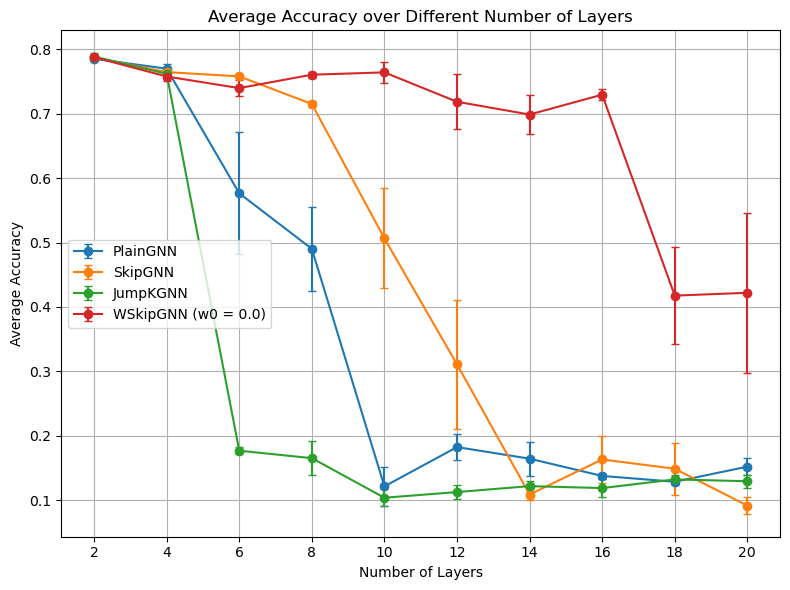

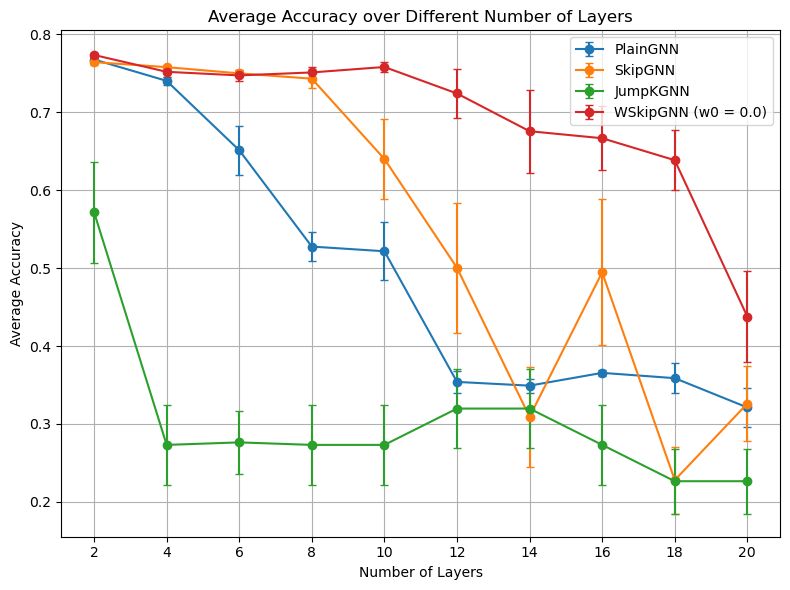

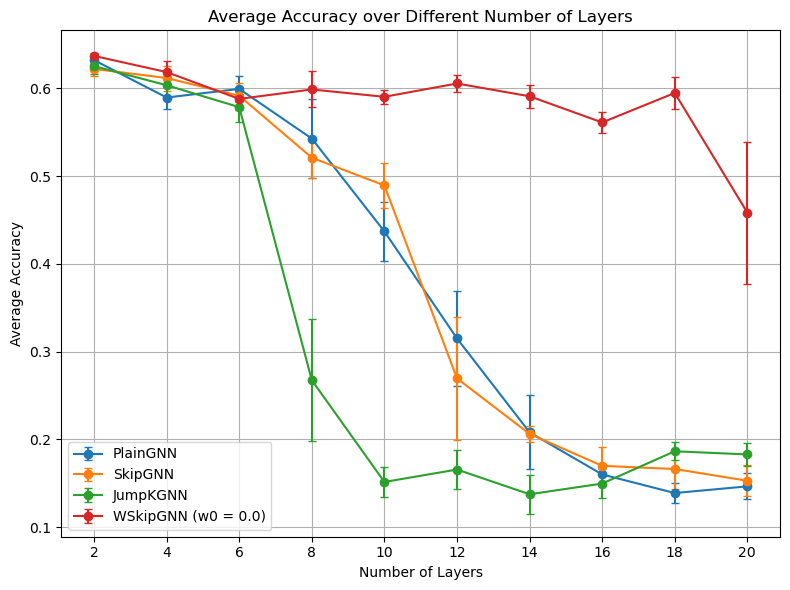

In [102]:
plot_acc_vs_nlayers(cora_results, 'Cora')
plot_acc_vs_nlayers(pubmed_results, 'PubMed')
plot_acc_vs_nlayers(citeseer_results, 'CiteSeer')

In [103]:
extract_all_init_res_weights(cora_results, layers=TRAIN_LAYERS)

{2: [-0.20000000000000018,
  -0.20000000000000018,
  0.3999999999999997,
  -1.0,
  -0.20000000000000018],
 4: [-2.220446049250313e-16,
  -0.8,
  -1.0,
  -0.6000000000000001,
  0.19999999999999973],
 6: [-0.6000000000000001,
  0.9999999999999996,
  -0.20000000000000018,
  -0.8,
  0.9999999999999996],
 8: [-1.0, -0.20000000000000018, -1.0, -0.6000000000000001, -0.8],
 10: [-0.6000000000000001, -1.0, -0.8, -0.8, -0.8],
 12: [-1.0, -0.8, -1.0, -1.0, -0.8],
 14: [-0.6000000000000001, -1.0, -1.0, -0.8, -1.0],
 16: [-0.8, -1.0, -1.0, -0.8, -1.0],
 18: [-0.8, -0.8, -0.8, 0.7999999999999996, -0.8],
 20: [-0.8, -1.0, -1.0, -1.0, -0.8]}

## Visualisation

In [109]:
def gen_sample_results(dataset_name, experiment_results, 
                       export_results=True):
    '''
    Returns sample results as a dictionary of 
    model : { num layers : (layers_to_model, layers_to_results, layers_to_hyperparams) }
    for all models.
    '''
    layers_to_init_ws = extract_all_init_res_weights(experiment_results)
    layers_to_mean_init_ws = { n: np.mean(ws) for n,ws in layers_to_init_ws.items() } # use mean
    model_to_hyperparams = { m : {n: training_params(m, dataset_name, n_layers=n, 
                                                     init_res_weight=layers_to_init_ws[n]) 
                                 for n in TRAIN_LAYERS }
                            for m in MODELS }
    
    flatten_single_dict = (lambda triple, n: (triple[0][n], triple[1][n], triple[2][n]))
    sample_results = {model: { n: flatten_single_dict(
                                        train_and_test(layers_to_params[n], layers=[n], 
                                                       print_results=False), n)
                              for n in TRAIN_LAYERS }
                      for model, layers_to_params in model_to_hyperparams.items() }
    return sample_results

Generate reduced embeddings for each model and save them in a dictionary object

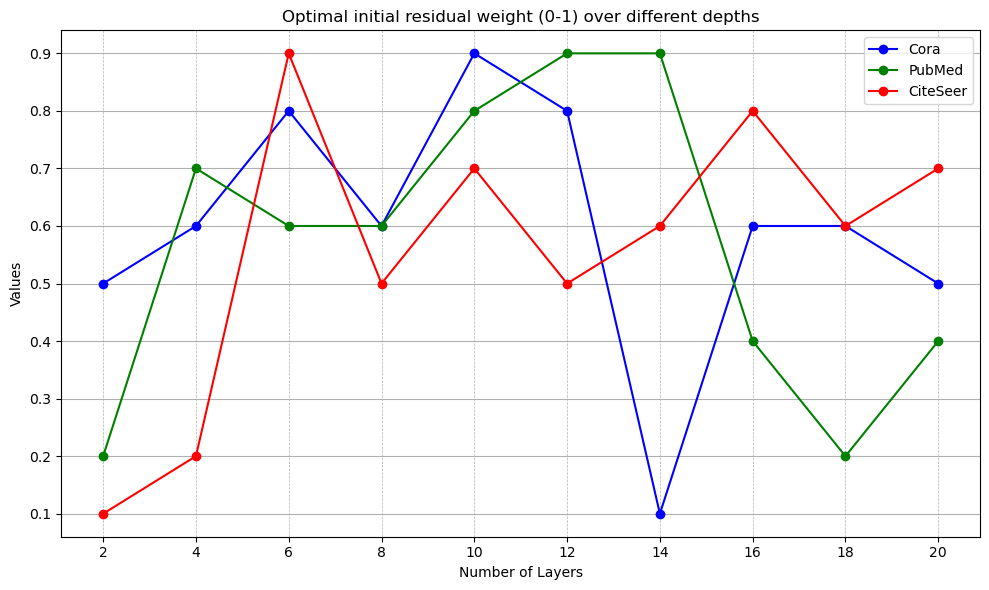

In [110]:
%run utils.ipynb

In [111]:
def visualise_embeddings_for_all_models(experiment_results, dataset_name):
    sample_results = gen_sample_results(dataset_name, experiment_results, export_results=False)
    for model_name, layers_to_results in sample_results.items():
        models = { n: res[0] for n, res in layers_to_results.items() }
        visualise_embeddings(models, model_name, dataset_name)

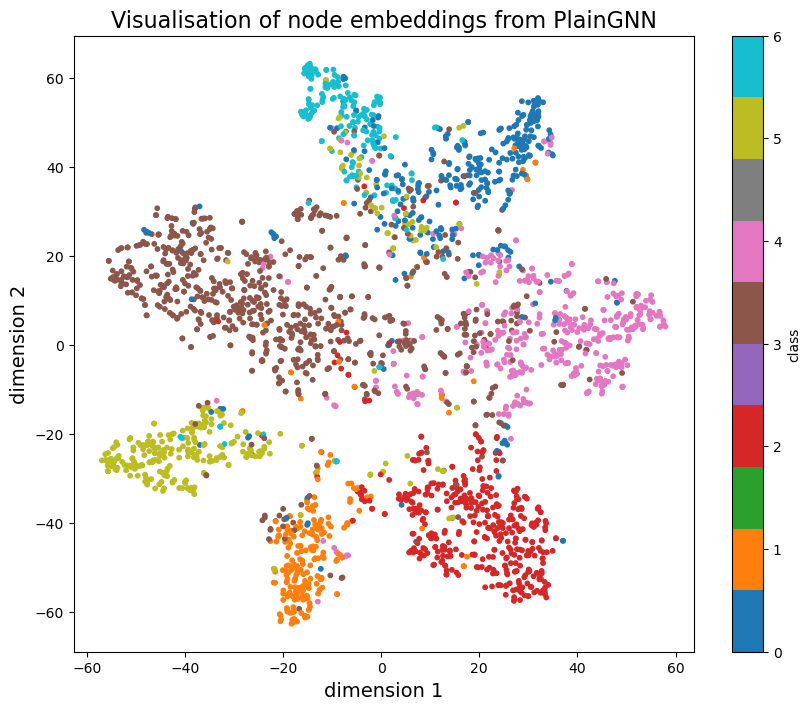

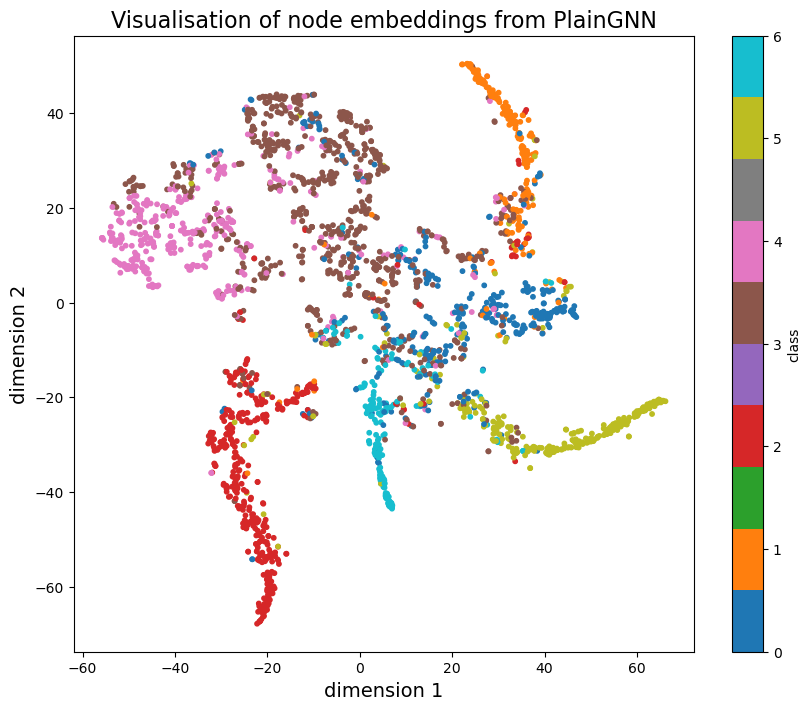

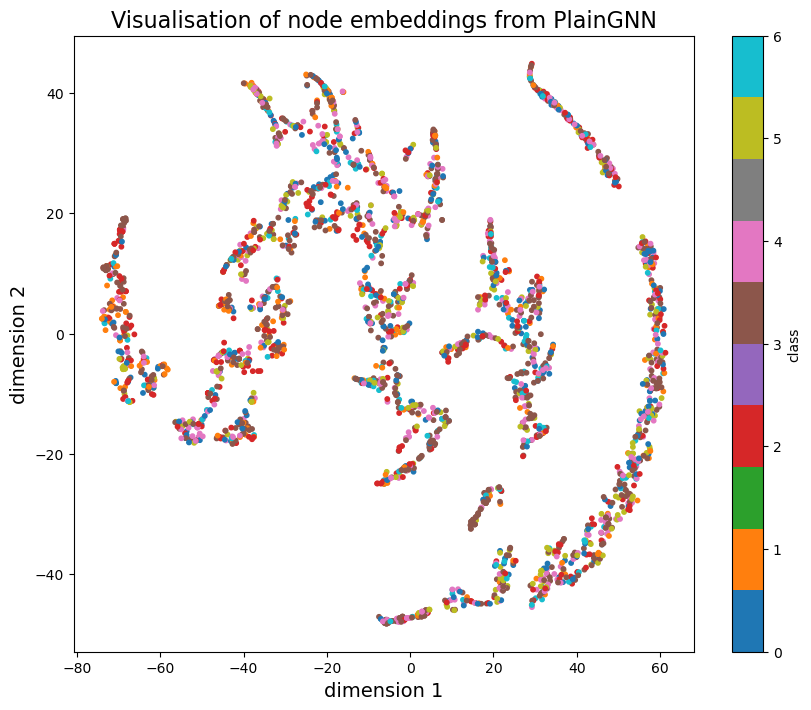

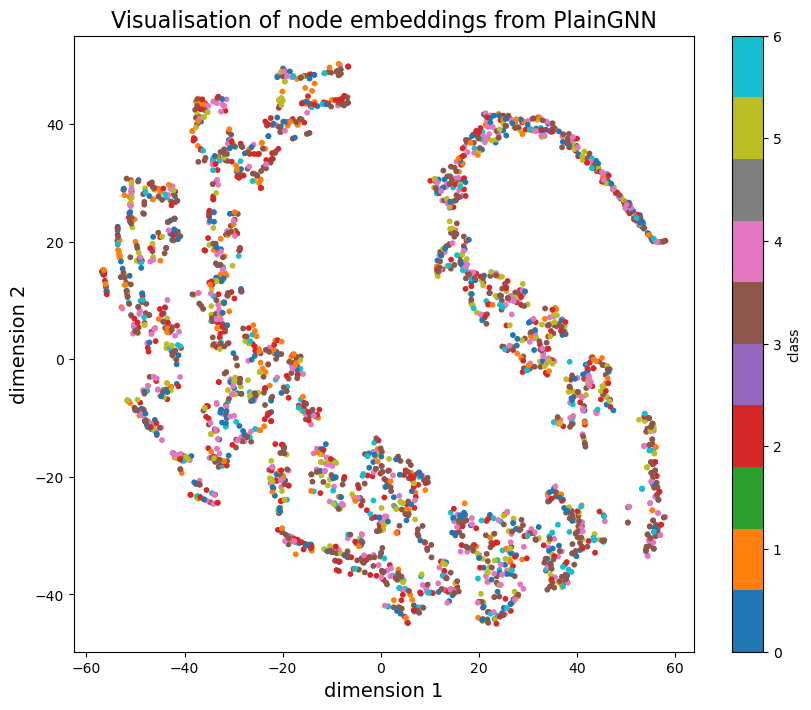

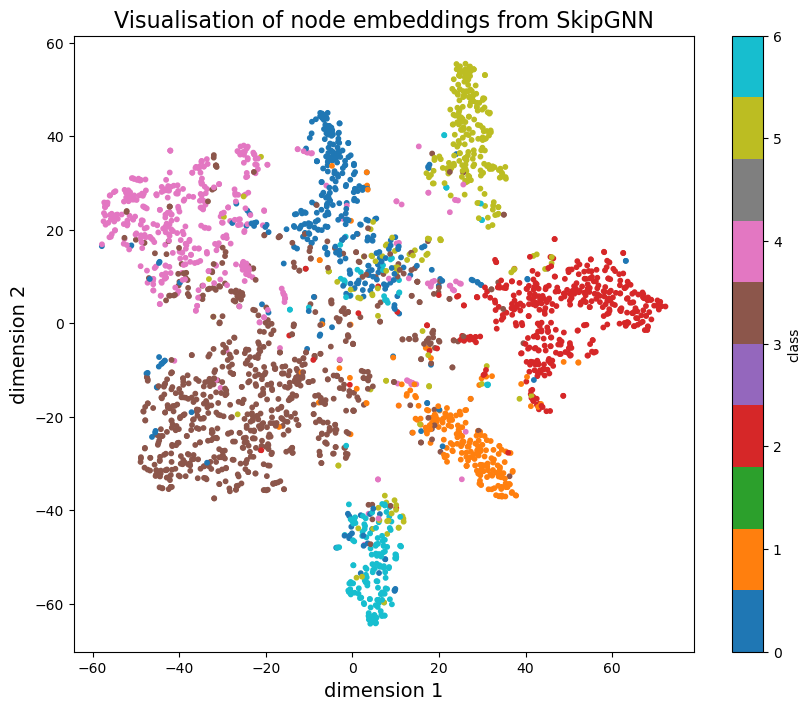

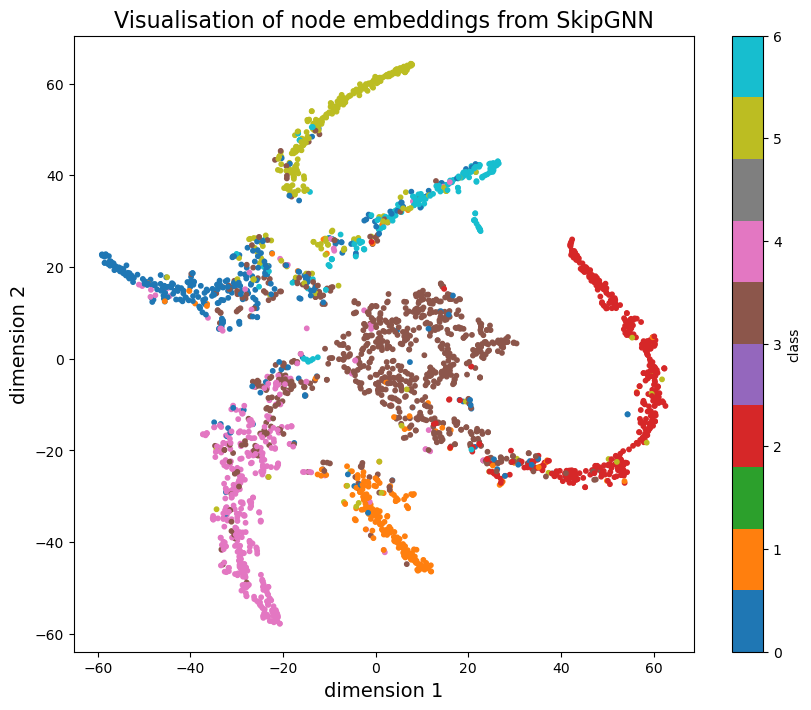

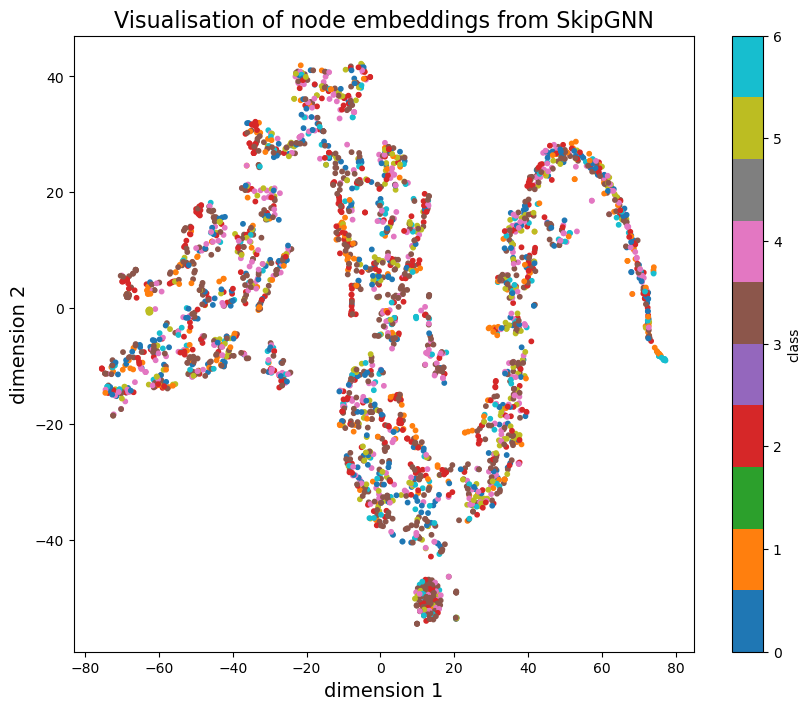

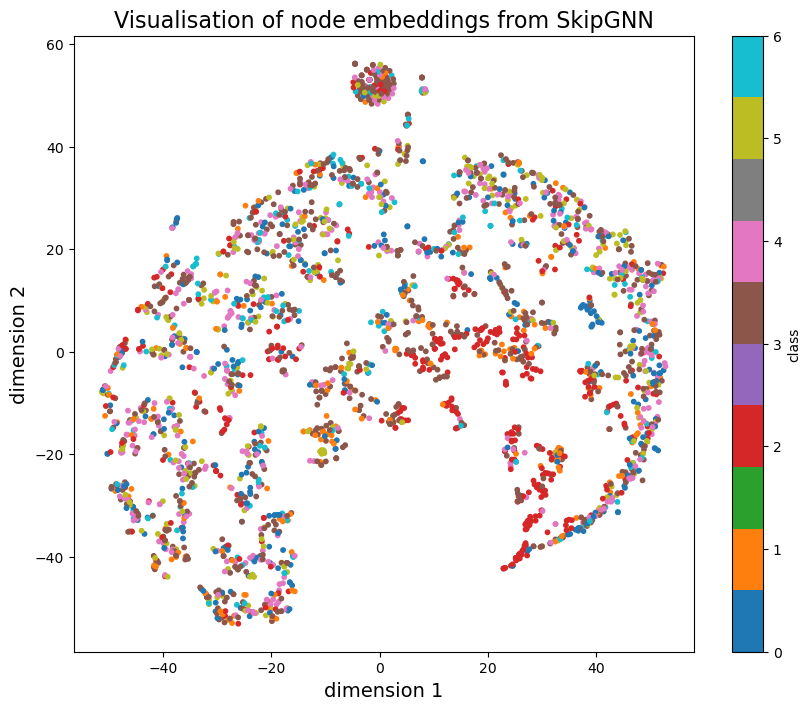

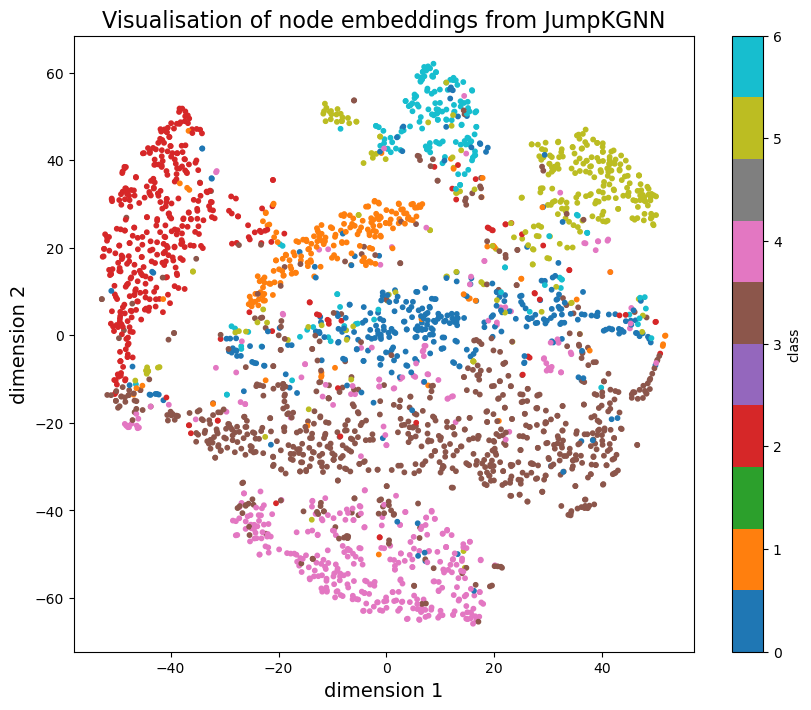

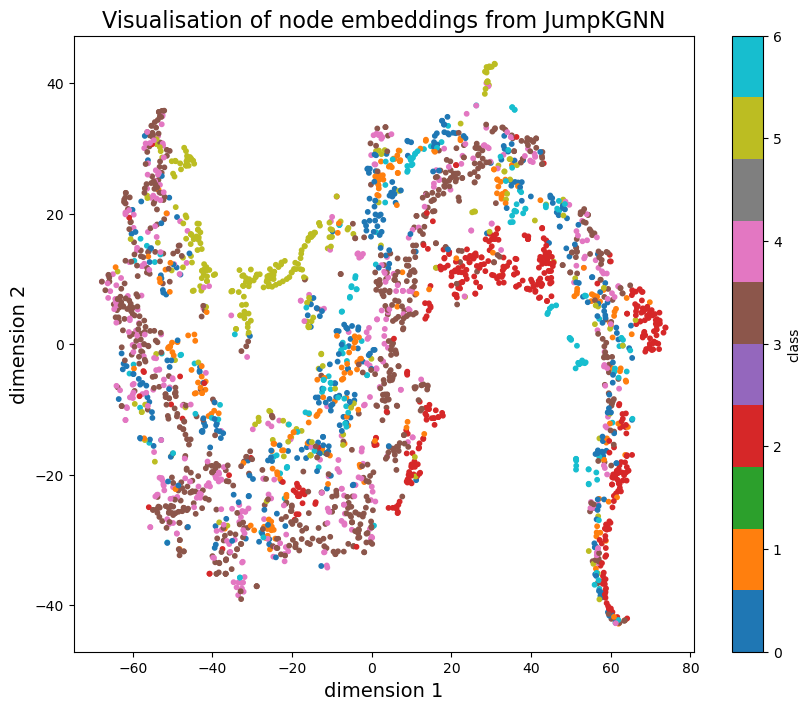

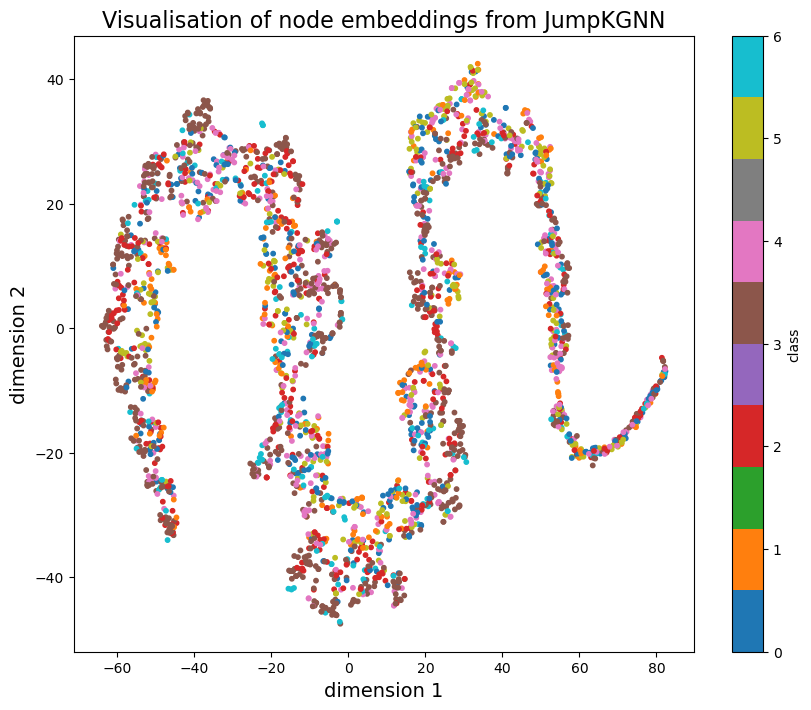

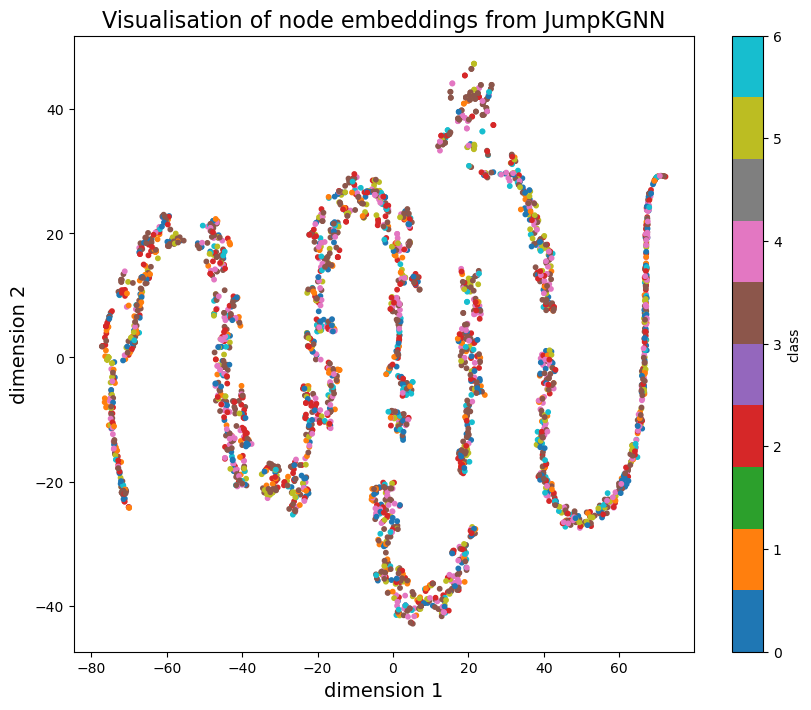

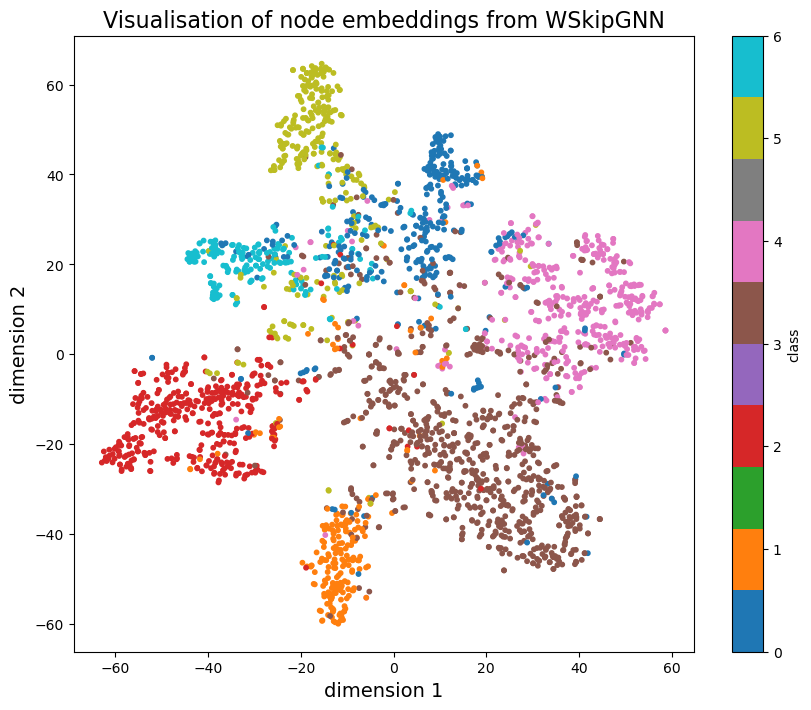

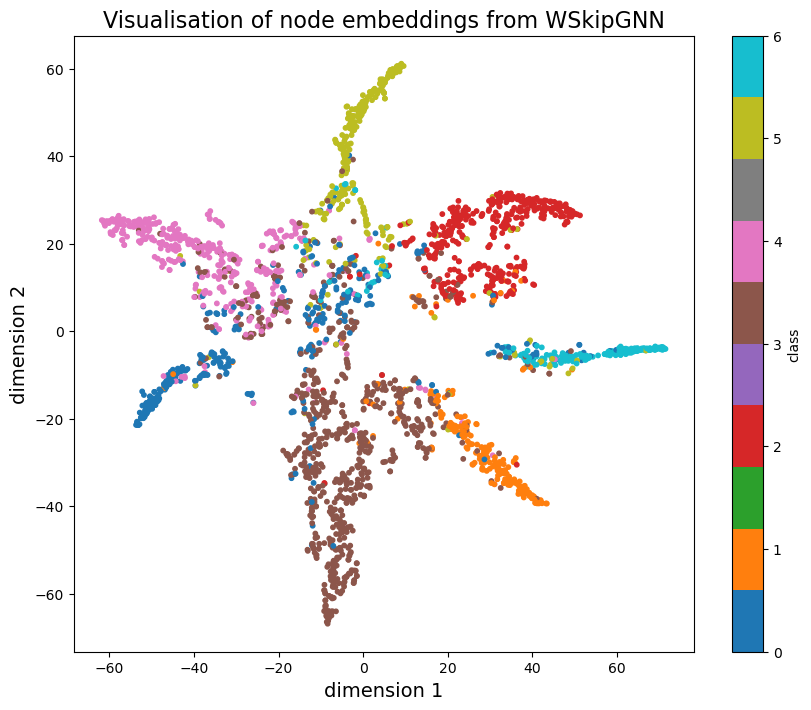

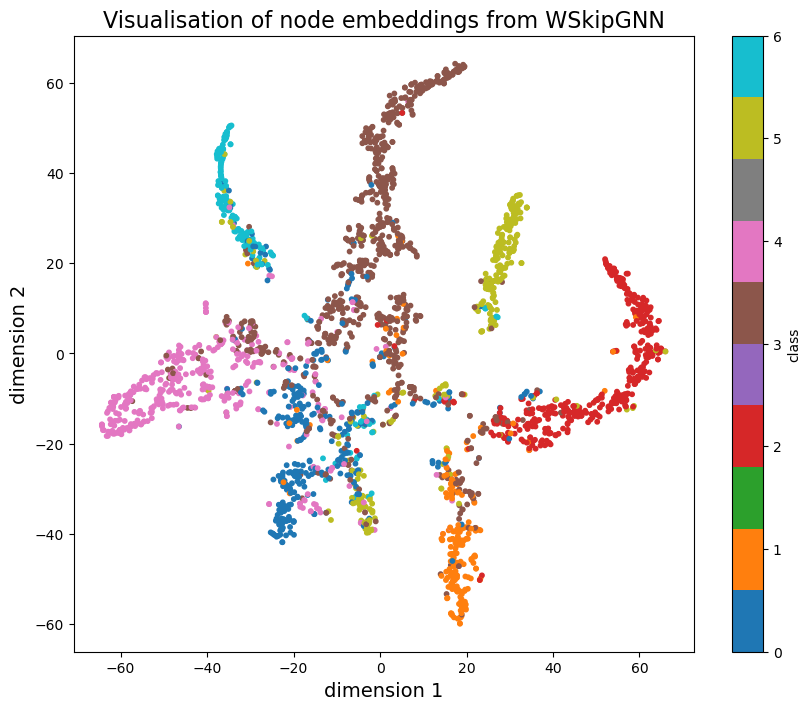

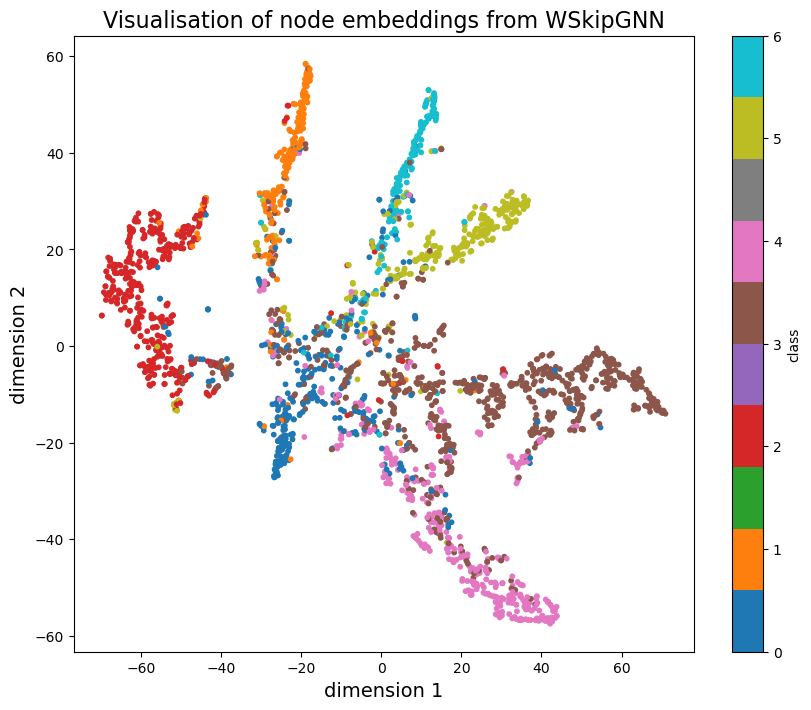

In [112]:
visualise_embeddings_for_all_models(cora_results, 'Cora')

In [115]:
visualise_embeddings_for_all_models(pubmed_results, 'PubMed')
visualise_embeddings_for_all_models(citeseer_results, 'CiteSeer')

IndexError: tuple index out of range